In [1]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss

def voltage_criterion(data=None, v_thresh=-40, time_thresh=260):
    threshold_crossings = np.diff(data > v_thresh, prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    # If length of threshold_crossings is not even
    if np.mod(np.argwhere(threshold_crossings).reshape(-1,).shape[0],2)!=0:
        legit_up_crossings = upward_crossings[:-1][np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
    else:
        legit_up_crossings = upward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
    return upward_crossings, legit_up_crossings, legit_down_crossings

# Input: upward and downward crossings
# Output: bounds of NMDA spikes meeting current criterion
def current_criterion(legit_uc_iso=[], legit_dc_iso=[], p=1, control_inmda=np.array([1])):
    bounds = []
    sum_current = []
    

    for ind1 in np.arange(0,len(legit_uc_iso)):
        e1 = control_inmda[legit_uc_iso[ind1], p] #current @ up_crossing[ind1]
        #all the indices where current crosses 130% of e1
        x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
        #all the indices where current crosses 115% of e1
        x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))
        
        if len(x30)>0:
        
            x15_copy = x15
            x30_copy = x30
            
            try:
                i = x30[0][0]
            except:
                import pdb; pdb.set_trace()
                
            n = 0
            
            
            while n==0:
                if len(np.sort(x15[x15>i]))!=0:
                    b1 = i
                    b2 = np.sort(x15[x15>i])[0]
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                else:
                    b1 = i
                    b2 = (legit_dc_iso[ind1]-legit_uc_iso[ind1])
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                    n=1
                
                x30_copy = x30_copy[x30_copy>legit_uc_iso[ind1]+b2]
                #import pdb; pdb.set_trace()
                
                if len(x30_copy)!=0:
                    i = x30_copy[x30_copy>b2][0]
                else:
                    n=1
    return bounds, sum_current



In [2]:
%cd ../scripts/L5BaselineResults/

/home/drfrbc/Neural-Modeling/scripts/L5BaselineResults


In [3]:
# output_folder = 'output_control'

# conns = pd.read_csv('./{}/Connections.csv'.format(output_folder))
conns = pd.read_csv('Connections.csv')

In [4]:
conns.loc[conns.Type=='dend','Sec ID'] = conns.loc[conns.Type=='dend','Name'].apply(lambda x: int(x.split('dend[')[1].split(']')[0]))
conns.loc[conns.Type=='apic','Sec ID'] = conns.loc[conns.Type=='apic','Name'].apply(lambda x: int(x.split('apic[')[1].split(']')[0]))
conns.loc[conns.Type=='soma','Sec ID'] = conns.loc[conns.Type=='soma','Name'].apply(lambda x: int(x.split('soma[')[1].split(']')[0]))
conns.loc[conns.Type=='axon','Sec ID'] = conns.loc[conns.Type=='axon','Name'].apply(lambda x: int(x.split('axon[')[1].split(']')[0]))

conns['X'] = conns['Name'].apply(lambda x: float(x.split('(')[1].split(')')[0]))

conns.rename(columns={'Distance':'conns_Distance'},inplace=True)

conns['Sec ID'] = conns['Sec ID'].astype(int)
conns['X'] = conns['X'].astype(float)

/tmp/ipykernel_547177/290075311.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  conns.loc[conns.Type=='axon','Sec ID'] = conns.loc[conns.Type=='axon','Name'].apply(lambda x: int(x.split('axon[')[1].split(']')[0]))


In [5]:
conns.head()

,Node ID,conns_Distance,Conductance,Type,Name,Source Population,Release Probability,Sec ID,X
0,0,61.505696,5.006073e-08,dend,L5PCtemplate[0].dend[60](0.264706),exc_stim,0.6,60,0.264706
1,0,112.522057,3.250785e-08,dend,L5PCtemplate[0].dend[28](0.128571),exc_stim,0.6,28,0.128571
2,0,73.494480,5.547277e-08,dend,L5PCtemplate[0].dend[29](0.7),exc_stim,0.6,29,0.700000
3,0,101.530468,1.005930e-07,dend,L5PCtemplate[0].dend[33](0.264706),exc_stim,0.6,33,0.264706
4,0,65.675576,3.045596e-08,dend,L5PCtemplate[0].dend[48](0.409091),exc_stim,0.6,48,0.409091


In [6]:
segs = pd.read_csv('Segments.csv')
segs_degrees = pd.read_csv('SegmentsDegrees.csv').groupby(['Type','Sec ID'])['Degrees'].max().reset_index()
segs['segmentID'] = segs.index
segs = segs.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index()

segs['Sec ID'] = segs['Sec ID'].astype(int)
segs['X'] = segs['X'].astype(float)
segs['Elec_distanceQ'] = 'None'

segs.loc[segs.Type=='dend','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='dend','Elec_distance'], 10, labels=False)
segs.loc[segs.Type=='apic','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='apic','Elec_distance'], 10, labels=False)

In [ ]:
# v = h5py.File('./{}/v_report.h5'.format(output_folder),'r')
# hva = h5py.File('./{}/Ca_HVA.ica_report.h5'.format(output_folder),'r')
# lva = h5py.File('./{}/Ca_LVAst.ica_report.h5'.format(output_folder),'r')
# ih = h5py.File('./{}/Ih.ihcn_report.h5'.format(output_folder),'r')

# nmda = h5py.File('./{}/inmda_report.h5'.format(output_folder),'r')

# na = h5py.File('./{}/NaTa_t.gNaTa_t_report.h5'.format(output_folder),'r')
# spks = h5py.File('./{}/spikes.h5'.format(output_folder),'r')

v = h5py.File('v_report.h5','r')
hva = h5py.File('Ca_HVA.ica_report.h5','r')
lva = h5py.File('Ca_LVAst.ica_report.h5','r')
ih = h5py.File('Ih.ihcn_report.h5','r')

nmda = h5py.File('inmda_report.h5','r')

na = h5py.File('NaTa_t.gNaTa_t_report.h5','r')
spks = h5py.File('spikes.h5','r')

In [ ]:
spktimes = spks['spikes']['biophysical']['timestamps'][:]
spkinds = np.sort((spktimes*10).astype(int))

In [ ]:
na_df = pd.DataFrame(columns=['segmentID','na_lower_bound'])

for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index:
    # print(p)
    threshold_crossings = np.diff(na['report']['biophysical']['data'][:,p] > 0.003, prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    # Only count if not within 2 ms after a somatic spike
    na_spks = [i for i in upward_crossings if ~np.any((i-spkinds>=-5) & (i-spkinds<50))]
    
#     if len(na_spks)>0:
#         na_df = na_df.append(pd.DataFrame({'segmentID':np.tile(p,len(na_spks)),
#                                                'na_lower_bound':na_spks}))
#     else:
#         na_df = na_df.append(pd.DataFrame({'segmentID':p,
#                                                'na_lower_bound':np.array([np.nan])}))
    
    #df.append is depracated; have to use pd.concat.
    if len(na_spks) > 0:
        new_rows = pd.DataFrame({'segmentID': np.tile(p, len(na_spks)),
                                 'na_lower_bound': na_spks})
    else:
        new_rows = pd.DataFrame({'segmentID': [p],
                                 'na_lower_bound': [np.nan]})
    
    na_df = pd.concat([na_df, new_rows], ignore_index=True)


In [7]:
exc_syns_per_seg = conns[conns['Source Population']=='exc_stim'].groupby(['Type','Sec ID','X'])['Conductance'].count().reset_index().rename(columns={'Conductance':'num_syns'})

inh_conns = conns[(conns['Source Population']=='dist_inh_stim')|
                  (conns['Source Population']=='prox_inh_stim')].sort_values(by=['Type','Sec ID','X']).reset_index(drop=True)
inh_syns_per_seg = inh_conns.groupby(['Type','Sec ID','X'])['Conductance'].count().reset_index().rename(columns={'Conductance':'num_syns'})

segs['segmentID'] = segs.groupby(['Type','Sec ID']).cumcount()+1

exc_syns_per_seg['segmentID'] = exc_syns_per_seg.groupby(['Type','Sec ID']).cumcount()+1
inh_syns_per_seg['segmentID'] = inh_syns_per_seg.groupby(['Type','Sec ID']).cumcount()+1

exc_syns = segs.set_index(['Type','Sec ID','segmentID']).join(exc_syns_per_seg[['Type','Sec ID','segmentID','num_syns']].set_index(['Type','Sec ID','segmentID'])).reset_index()
inh_syns = segs.set_index(['Type','Sec ID','segmentID']).join(inh_syns_per_seg[['Type','Sec ID','segmentID','num_syns']].set_index(['Type','Sec ID','segmentID'])).reset_index()



In [8]:
exc_syns[exc_syns.Type=='apic']['num_syns'].sum() / exc_syns[exc_syns.Type=='apic']['Section_L'].unique().sum()

2.1647901629711943

In [9]:
exc_syns[exc_syns.Type=='dend']['num_syns'].sum() / exc_syns[exc_syns.Type=='dend']['Section_L'].unique().sum()

1.967666458778837

In [ ]:
na_df.reset_index(inplace=True)

In [15]:
def reshape_pad(v, fillval=np.nan):
    lens = np.array([len(item) for item in v])
    mask = lens[:,None] > np.arange(lens.max())
    out = np.full(mask.shape,fillval)
    out[mask] = np.concatenate(v)
    return out

In [ ]:
# get the value of the conductance at the peak
df = pd.DataFrame(columns=['segmentID','na_lower_bound','peak_value'])

for s in na_df[~pd.isnull(na_df.na_lower_bound)].segmentID.unique():

    inds = na_df[na_df.segmentID==s]['na_lower_bound'].astype(int).values
    
    L = np.split(na['report']['biophysical']['data'][:,s], inds)
    
    X = reshape_pad(L)
    
    peak_vals = np.max(X[:,0:10], axis=1)
    
    df = pd.concat((df,pd.DataFrame({'segmentID': s*np.ones((inds.shape[0],)).astype(int),
                                     'na_lower_bound': inds, 
                                     'peak_value': peak_vals[1:]})))
    
    # print(s)

In [ ]:
na_df.to_csv('na_df.csv',index=False)

<Axes: >

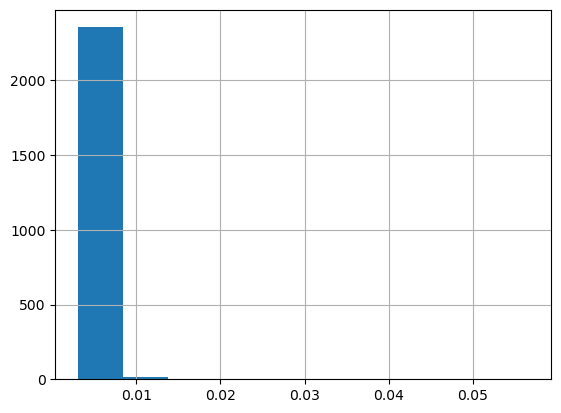

In [18]:
df.groupby('segmentID')['peak_value'].mean().hist()

In [19]:
df_gb = df.groupby('segmentID')['na_lower_bound'].count().sort_values().reset_index()

In [20]:
outliers = df_gb[df_gb.na_lower_bound>1000]['segmentID'].values

In [21]:
df_noout = df[(df.segmentID.isin(outliers))&(df.peak_value>0.006)]

In [22]:
df_noout.head()

,segmentID,na_lower_bound,peak_value
5,99,11936,0.011013
8,99,18976,0.009053
10,99,24703,0.006821
12,99,29522,0.006711
14,99,35540,0.012622


In [23]:
na_df.head()

,index,segmentID,na_lower_bound
0,0,0,367474
1,1,0,1047561
2,2,1,367474
3,3,1,1047561
4,4,2,367474


In [24]:
# #** added cell
# # Check the columns of df_noout and na_df
# print(df_noout.columns)
# print(na_df.columns)

# # If 'peak_value' is missing from na_df, ensure it exists
# # Also, make sure 'segmentID' and 'na_lower_bound' exist
# if 'peak_value' in df_noout.columns and 'peak_value' in na_df.columns:
#     na_df_new = pd.concat((df_noout[['segmentID', 'na_lower_bound', 'peak_value']],
#                            na_df.loc[~na_df.segmentID.isin(outliers), ['segmentID', 'na_lower_bound', 'peak_value']]))
# else:
#     print("One or more columns are missing in the dataframes.")

# # Example of na_peak_values creation from df_noout
# na_peak_values = df_noout[['segmentID', 'peak_value']].drop_duplicates()

# # Merge na_df with na_peak_values to get peak_value
# na_df = na_df.merge(na_peak_values, on='segmentID', how='left')

# # Now you can concatenate
# na_df_new = pd.concat((df_noout[['segmentID', 'na_lower_bound', 'peak_value']],
#                        na_df.loc[~na_df.segmentID.isin(outliers), ['segmentID', 'na_lower_bound', 'peak_value']]))


In [25]:
na_df_new = pd.concat((df_noout[['segmentID','na_lower_bound','peak_value']],
                       na_df.loc[~na_df.segmentID.isin(outliers),['segmentID','na_lower_bound']]))#,'peak_value']])) **change because na_df does not have peak value.

In [26]:
na_df_new.to_csv('na_df.csv',index=False)

<Axes: >

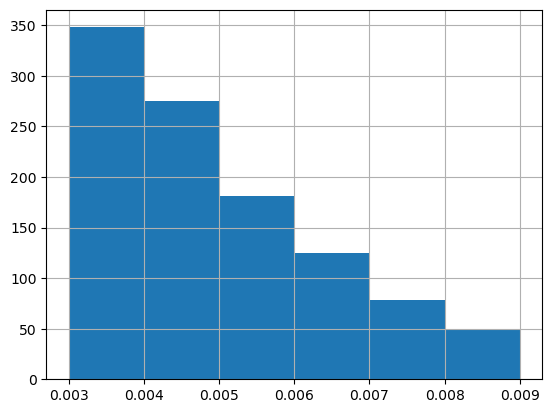

In [27]:
df.loc[df.segmentID==936,'peak_value'].hist(bins=np.arange(0.003,0.01,0.001))

In [28]:
#for i in na_df.segmentID.unique():
#    seg = na_df.loc[i,'segmentID']
#    if not pd.isnull(na_df.loc[i,'na_lower_bound']):
#        spkt = int(na_df.loc[i,'na_lower_bound'])
#        trace = na['report']['biophysical']['data'][spkt-10:spkt+10,seg]
#        peak_value = np.max(trace)
#        half_peak = peak_value/2
#        duration = np.arange(0,20)[trace>half_peak] + spkt - 10
#        na_df.loc[i,'duration_low'] = duration[0]
#        na_df.loc[i,'duration_high'] = duration[-1]
#        na_df.loc[i,'peak_value'] = peak_value
#    else:
#        na_df.loc[i,'duration_low'] = np.nan
#        na_df.loc[i,'duration_high'] = np.nan
#        na_df.loc[i,'peak_value'] = np.nan
#        
#na_df['duration'] = (na_df['duration_high'] - na_df['duration_low'] + 1)/10

In [29]:
#na_df.to_csv('64Hz_soma_inh_na_df.csv')
#na_df = pd.read_csv('na_df.csv')

## Plot example events

In [30]:
na_df[na_df.segmentID==101].sort_values(by='na_lower_bound').head()

,index,segmentID,na_lower_bound
34136,34136,101,2963
34137,34137,101,4545
34138,34138,101,6810
34139,34139,101,8614
34140,34140,101,10455


In [31]:
# ina = h5py.File('./output/NaTa_t.ina_report.h5','r')
# ina = h5py.File('NaTa_t.ina_report.h5','r') # ** removed. we do not have ina_report saved.

In [32]:
# np.median(ina['report']['biophysical']['data'][:,101]) # ** removed. we do not have ina_report saved.

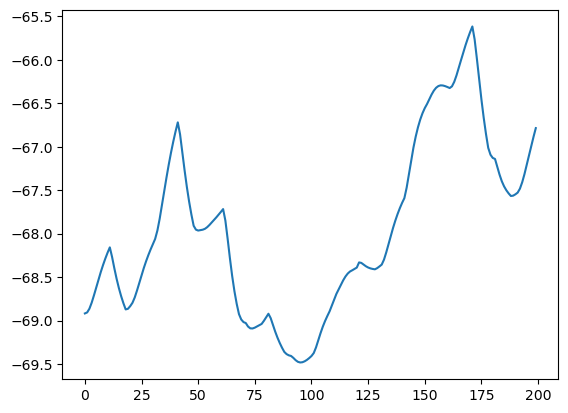

In [33]:
plt.plot(v['report']['biophysical']['data'][8500:8700,0])

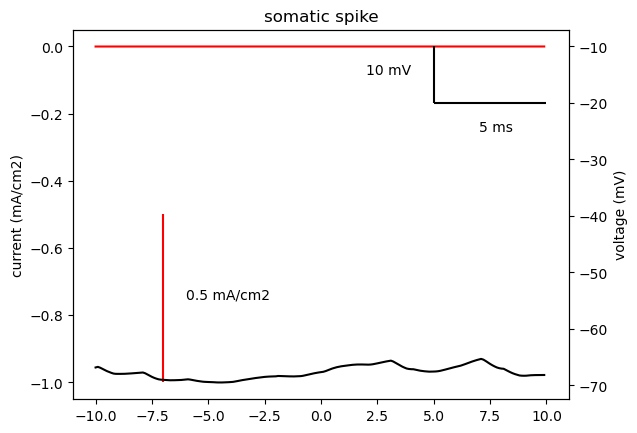

In [34]:
t = 8640
plt.plot(np.arange(-10,10,.1), (v['report']['biophysical']['data'][t-100:t+100,0]-45)*na['report']['biophysical']['data'][t-100:t+100,0],color='r')
plt.vlines(-7,-0.5,-1,color='r')
#plt.hlines(0,-10,10,color='r',linestyle='dashed',alpha=0.2)
plt.text(-6,-0.75,'0.5 mA/cm2')
plt.ylabel('current (mA/cm2)')

plt.twinx()
plt.plot(np.arange(-10,10,.1), v['report']['biophysical']['data'][t-100:t+100,0],color='k')
plt.vlines(5,-10,-20,color='k')
plt.hlines(-20,5,10,color='k')
#plt.hlines(-60,-10,10,color='k',linestyle='dashed',alpha=0.2)
#plt.text(10,-60,'-60 mV')
plt.ylabel('voltage (mV)')
plt.text(7,-25,'5 ms')
plt.text(2,-15,'10 mV')
plt.title('somatic spike')

plt.savefig('exSomaspike.svg')

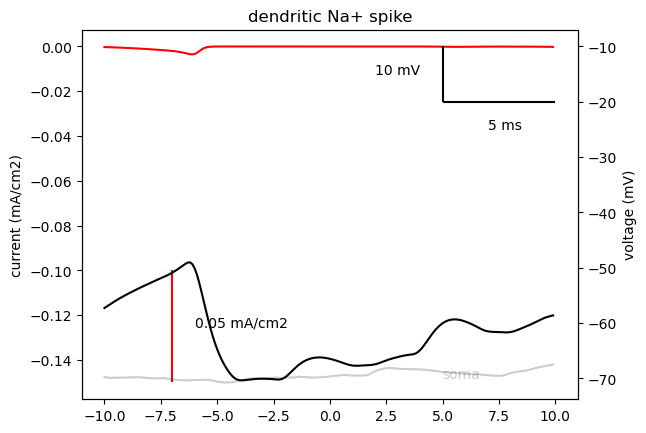

In [35]:
t = 5325
plt.plot(np.arange(-10,10,.1), (v['report']['biophysical']['data'][t-100:t+100,101]-45)*na['report']['biophysical']['data'][t-100:t+100,101],color='r')
plt.vlines(-7,-0.1,-0.15,color='r')
#plt.hlines(0,-10,10,color='r',linestyle='dashed',alpha=0.2)
plt.text(-6,-0.125,'0.05 mA/cm2')
plt.ylabel('current (mA/cm2)')

plt.twinx()
plt.plot(np.arange(-10,10,.1), v['report']['biophysical']['data'][t-100:t+100,101],color='k')
plt.plot(np.arange(-10,10,.1), v['report']['biophysical']['data'][t-100:t+100,0],color='k',alpha=0.2)
plt.text(5,-70,'soma',alpha=0.2)
plt.vlines(5,-10,-20,color='k')
plt.hlines(-20,5,10,color='k')
#plt.hlines(-60,-10,10,color='k',linestyle='dashed',alpha=0.2)
#plt.text(10,-60,'-60 mV')
plt.ylabel('voltage (mV)')
plt.text(7,-25,'5 ms')
plt.text(2,-15,'10 mV')
plt.title('dendritic Na+ spike')

plt.savefig('exNaspike.svg')

In [36]:
# nmda_df = pd.read_csv('nmda_df.csv') #** change: nmda_df.csv does not exist yet?

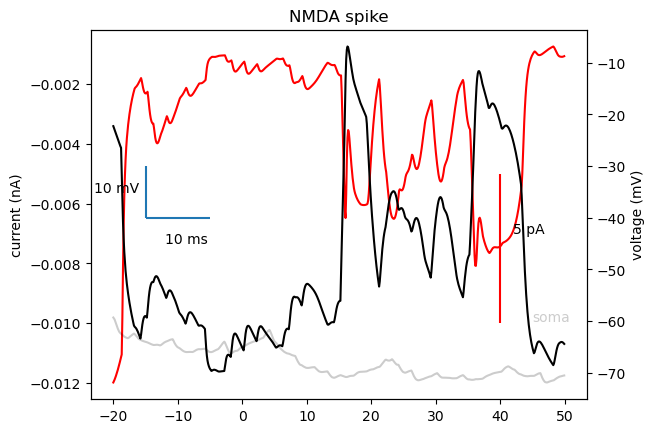

In [37]:
t = 643309
s = 76

plt.plot(np.arange(-20,50,.1),nmda['report']['biophysical']['data'][t-200:t+500,s],color='r')
plt.vlines(40,-0.005,-0.01,color='r')
plt.text(42,-0.007,'5 pA')
plt.ylabel('current (nA)')

plt.twinx()

plt.plot(np.arange(-20,50,.1),v['report']['biophysical']['data'][t-200:t+500,s],color='k')
plt.plot(np.arange(-20,50,.1),v['report']['biophysical']['data'][t-200:t+500,0],color='k',alpha=0.2)
plt.text(45,-60,'soma',alpha=0.2)
plt.hlines(-40,-15,-5)
plt.vlines(-15,-30,-40)
plt.text(-23,-35,'10 mV')
plt.text(-12,-45,'10 ms')
plt.ylabel('voltage (mV)')
plt.title('NMDA spike')
plt.savefig('NMDAspike.svg')

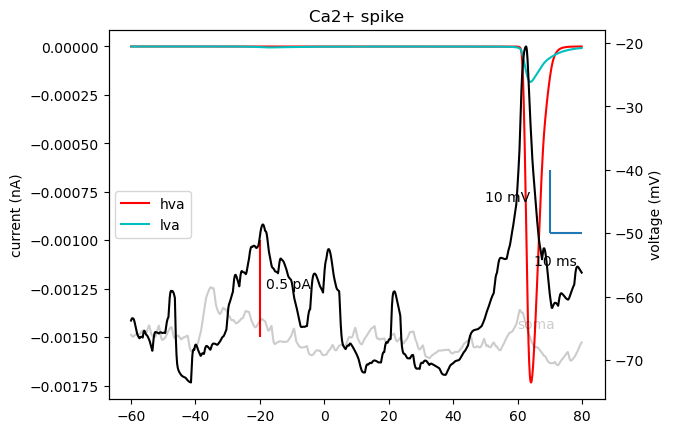

In [38]:
t = 1090075
s = 1312

plt.plot(np.arange(-60,80,.1),hva['report']['biophysical']['data'][t-600:t+800,s],color='r',label='hva')
plt.plot(np.arange(-60,80,.1),lva['report']['biophysical']['data'][t-600:t+800,s],color='c',label='lva')
plt.legend(loc='center left')
plt.vlines(-20,-0.001,-0.0015,color='r')
plt.text(-18,-0.00125,'0.5 pA')
plt.ylabel('current (nA)')

plt.twinx()

plt.plot(np.arange(-60,80,.1),v['report']['biophysical']['data'][t-600:t+800,s],color='k')
plt.plot(np.arange(-60,80,.1),v['report']['biophysical']['data'][t-600:t+800,0],color='k',alpha=0.2)
plt.hlines(-50,70,80)
plt.text(65,-55,'10 ms')
plt.vlines(70,-40,-50)
plt.text(50,-45,'10 mV')
plt.ylabel('voltage (mV)')
plt.title('Ca2+ spike')
plt.text(60,-65,'soma',alpha=0.2)
plt.savefig('Caspike.svg')

In [39]:
for i in np.random.choice(na_df[(na_df.na_lower_bound>20) & (na_df.na_lower_bound<1400000)].index,10000):
    seg = na_df.loc[i,'segmentID']
    if not pd.isnull(na_df.loc[i,'na_lower_bound']):
        spkt = int(na_df.loc[i,'na_lower_bound'])
        trace = na['report']['biophysical']['data'][spkt-10:spkt+10,seg]
        peak_value = np.max(trace)
        half_peak = peak_value/2
        duration = np.arange(0,20)[trace>half_peak] + spkt - 10
        na_df.loc[i,'duration_low'] = duration[0]
        na_df.loc[i,'duration_high'] = duration[-1]
        na_df.loc[i,'peak_value'] = peak_value
    else:
        na_df.loc[i,'duration_low'] = np.nan
        na_df.loc[i,'duration_high'] = np.nan
        na_df.loc[i,'peak_value'] = np.nan

In [40]:
na_df['duration'] = (na_df['duration_high'] - na_df['duration_low'] + 1)/10

In [41]:
na_df = pd.read_csv('na_df.csv')

In [42]:
segs_na_df = segs.set_index('segmentID').join(na_df.set_index('segmentID')).reset_index()

In [43]:
def get_sta(segs_na_df, spktimes):
    na_dend = np.zeros((10,39,))
    na_apic = np.zeros((10,39,))
    
    edges_dend=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='dend')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    edges_apic=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='dend')&
                                     (segs_na_df.Elec_distance>edges_dend[e])&
                                     (segs_na_df.Elec_distance<=edges_dend[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_dend[e] += x2
                
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='apic')&
                                     (segs_na_df.Elec_distance>edges_apic[e])&
                                     (segs_na_df.Elec_distance<=edges_apic[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
    return na_dend, na_apic

In [44]:
na_dend, na_apic = get_sta(segs_na_df, spktimes)
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))
na_dend_rand, na_apic_rand = get_sta(segs_na_df, rand_spktimes)

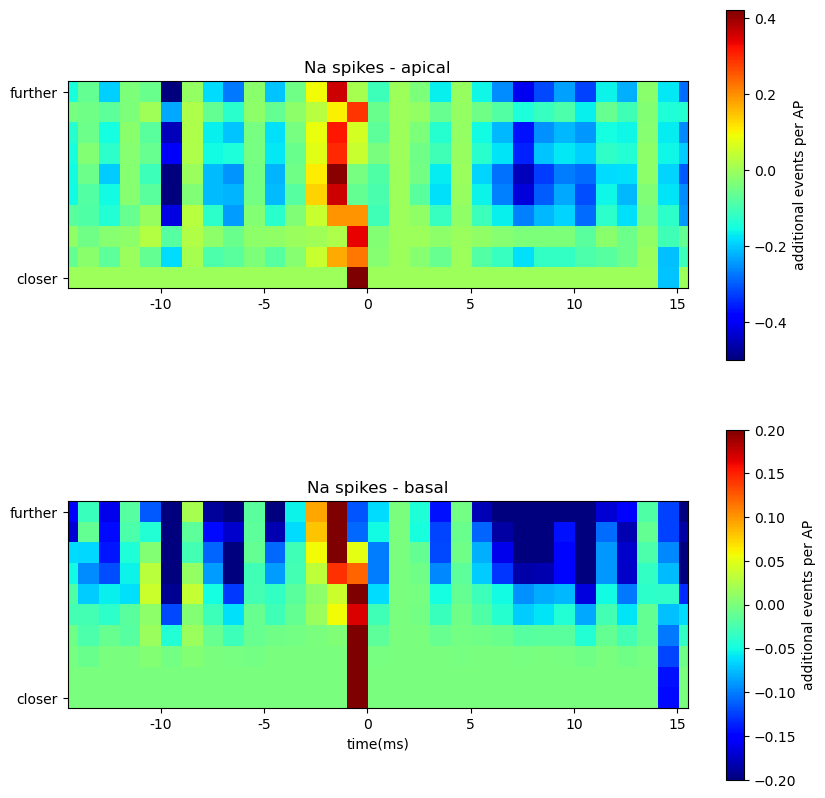

In [45]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Na spikes - apical')
plt.imshow((na_apic-na_apic_rand)/len(spktimes),cmap='jet',vmin=-0.5)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlim(5,35)

plt.subplot(2,1,2)
plt.title('Na spikes - basal')
plt.imshow((na_dend-na_dend_rand)/len(spktimes),cmap='jet',vmin=-0.2, vmax=0.2)
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlabel('time(ms)')
plt.xlim(5,35)
plt.savefig('naspikes.svg')
plt.show()


----------

In [46]:
segs = pd.read_csv('/Volumes/TOSHIBA EXT/L5NeuronSimulation_new/L5NeuronSimulation/MorphAnalysis/Segments.csv')
segs_degrees = pd.read_csv('SegmentsDegrees.csv').groupby(['Type','Sec ID'])['Degrees'].max().reset_index()
segs['segmentID'] = segs.index
segs = segs.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index()

segs['Sec ID'] = segs['Sec ID'].astype(int)
segs['X'] = segs['X'].astype(float)
segs['Elec_distanceQ'] = 'None'

segs.loc[segs.Type=='dend','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='dend','Elec_distance'], 10, labels=False)
segs.loc[segs.Type=='apic','Elec_distanceQ'] = pd.qcut(segs.loc[segs.Type=='apic','Elec_distance'], 10, labels=False)

FileNotFoundError: [Errno 2] No such file or directory: '/Volumes/TOSHIBA EXT/L5NeuronSimulation_new/L5NeuronSimulation/MorphAnalysis/Segments.csv'

In [ ]:
plt.scatter(segs['Coord X'], segs['Coord Y'])
plt.scatter(segs.loc[(segs['Coord Y']>500) & (segs['Coord Y']<700),'Coord X'],
            segs.loc[(segs['Coord Y']>500) & (segs['Coord Y']<700),'Coord Y'])

# Find Ca2+ spikes

In [ ]:
ca_df = pd.DataFrame(columns=['segmentID','ca_lower_bound'])
#&(segs['Coord Y']>630) & (segs['Coord Y']<830)
segIDs = segs[(segs.Type=='apic')&(segs['Coord Y']>400)&(segs['Coord Y']<1000)]['segmentID']
for p in segIDs:
    print(p)
    trace = hva['report']['biophysical']['data'][:,p]+\
                lva['report']['biophysical']['data'][:,p]+\
                ih['report']['biophysical']['data'][:,p]
    m = np.mean(trace)
    s = np.std(trace)

    legit_uc = voltage_criterion(data=v['report']['biophysical']['data'][:-10000,p],v_thresh=-40, time_thresh=200)[1]
    legit_dc = voltage_criterion(data=v['report']['biophysical']['data'][:-10000,p],v_thresh=-40, time_thresh=200)[-1]
    
    legit_uc_iso = legit_uc
    
    legit_dc_iso = legit_dc
    
    
    if (len(legit_uc_iso)!=0) & (np.min(trace)!=0):
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso, 
                                           legit_dc_iso=legit_dc_iso, 
                                           p=p, 
                                           control_inmda=hva['report']['biophysical']['data'])
        ca_df = ca_df.append(pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
                                               'ca_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'ca_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr}))
    
    else:
        ca_df = ca_df.append(pd.DataFrame({'segmentID':np.tile(p,1),
                                               'ca_lower_bound':np.nan,
                                               'ca_upper_bound':np.nan,
                                               'mag':np.nan}))

In [ ]:
ca_df.to_csv('ca_df.csv')
#ca_df = pd.read_csv('ca_df.csv')

In [ ]:
ca_df = pd.read_csv('ca_df.csv')
p = np.random.choice(ca_df[(~pd.isnull(ca_df.ca_lower_bound))].index)
ca_df.loc[p,'segmentID'], ca_df.loc[p,'ca_lower_bound']

## Plotting morphology as heat maps

In [ ]:
plt.figure(figsize=(4,10))
for i in exc_syns[exc_syns.Type=='apic']['Sec ID'].unique():
    plt.plot(exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Coord X'],
             exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Coord Y'],
             color='k',
             linewidth = 2*exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Section_diam'].unique())
    
for i in exc_syns[exc_syns.Type=='dend']['Sec ID'].unique():
    plt.plot(exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Coord X'],
         exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Coord Y'],
             color='k',
             linewidth = 2*exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Section_diam'].unique())
    

plt.scatter(exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord X'],
         exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord Y'],color='k',s=100)
plt.savefig('morphology.svg')

In [ ]:
color_field = 'Elec_distance'

ax = plt.figure(figsize=(2,5))
import matplotlib
from matplotlib.colors import Normalize
cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin = np.log10(exc_syns['Elec_distance'].min()), vmax = np.log10(exc_syns['Elec_distance'].max()))

for i in exc_syns[exc_syns.Type=='apic']['Sec ID'].unique():
    section = exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(np.log10(section.loc[j:j+1,color_field].values[0]))),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
    
for i in exc_syns[exc_syns.Type=='dend']['Sec ID'].unique():
    section = exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(np.log10(section.loc[j:j+1,color_field].values[0]))),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
        
plt.scatter(exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord X'],
         exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord Y'],color='k',s=100)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
#cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('Elec_distance.svg')

In [ ]:
color_field = 'Elec_distance_nexus'

ax = plt.figure(figsize=(2,5))
import matplotlib
from matplotlib.colors import Normalize
cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin = np.log10(exc_syns['Elec_distance'].min()), vmax = np.log10(exc_syns['Elec_distance'].max()))

for i in exc_syns[exc_syns.Type=='apic']['Sec ID'].unique():
    section = exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(np.log10(section.loc[j:j+1,color_field].values[0]))),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
    
for i in exc_syns[exc_syns.Type=='dend']['Sec ID'].unique():
    section = exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(np.log10(section.loc[j:j+1,color_field].values[0]))),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
        
plt.scatter(exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord X'],
         exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord Y'],color='k',s=100)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
#cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('Elec_distance_nexus.svg')

In [ ]:
exc_syns.head()

In [ ]:
exc_syns[(exc_syns['Coord Y']>500) & (exc_syns['Coord Y']<700)]['Sec ID'].unique()

In [ ]:
plt.plot(exc_syns[exc_syns.Type=='apic']['Coord X'],
         exc_syns[exc_syns.Type=='apic']['Coord Y'],'.')
plt.plot(exc_syns.loc[(exc_syns.Type=='apic')&(exc_syns['Section_diam']>1.0)]['Coord X'],
         exc_syns.loc[(exc_syns.Type=='apic')&(exc_syns['Section_diam']>1.0)]['Coord Y'],'r.')
plt.plot(exc_syns.loc[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==50)]['Coord X'],
         exc_syns.loc[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==50)]['Coord Y'],'m.')


In [ ]:
plt.plot(exc_syns[exc_syns.Type=='apic']['Sec ID'], exc_syns[exc_syns.Type=='apic']['Section_diam'], '.')

In [ ]:
exc_syns.loc[(pd.isnull(exc_syns.num_syns))|(exc_syns.num_syns>30),'num_syns'] = 0
inh_syns.loc[pd.isnull(inh_syns.num_syns),'num_syns'] = 0

In [ ]:
inh_syns_plot = inh_syns.copy()
inh_syns_plot.loc[inh_syns.num_syns==0,'num_syns'] = 1e-1

color_field = 'num_syns'

ax = plt.figure(figsize=(2,5))
import matplotlib
from matplotlib.colors import Normalize
cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 5)

for i in inh_syns_plot[inh_syns_plot.Type=='apic']['Sec ID'].unique():
    section = inh_syns_plot[(inh_syns_plot.Type=='apic')&(inh_syns_plot['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(section.loc[j:j+1,color_field].values[0])),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
    
for i in inh_syns_plot[inh_syns_plot.Type=='dend']['Sec ID'].unique():
    section = inh_syns_plot[(inh_syns_plot.Type=='dend')&(inh_syns_plot['Sec ID']==i)]
    for j in section.index.tolist()[:-1]:
        plt.plot(section.loc[j:j+1,'Coord X'],
                 section.loc[j:j+1,'Coord Y'],
             color=cmap(norm(section.loc[j:j+1,color_field].values[0])),
             linewidth = 1*section.loc[j:j+1,'Section_diam'].unique())
        
plt.scatter(inh_syns_plot[(inh_syns_plot.Type=='soma')&(inh_syns_plot['Sec ID']==0)].loc[2523,'Coord X'],
         inh_syns_plot[(inh_syns_plot.Type=='soma')&(inh_syns_plot['Sec ID']==0)].loc[2523,'Coord Y'],color='k',s=100)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
#cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('inh_syns.svg')

In [ ]:
inh_syns_plot = inh_syns.copy()
inh_syns_plot.loc[inh_syns.num_syns==0,'num_syns'] = 1e-1

color_field = 'num_syns'

ax = plt.figure(figsize=(4,4))
import matplotlib
from matplotlib.colors import Normalize
cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 0.8)

for i in inh_syns_plot[inh_syns_plot.Type=='apic']['Sec ID'].unique():
    section_L = inh_syns_plot[(inh_syns_plot.Type=='apic')&(inh_syns_plot['Sec ID']==i)]['Section_L'].unique()[0]
    plt.plot(inh_syns_plot[(inh_syns_plot.Type=='apic')&(inh_syns_plot['Sec ID']==i)]['Coord X'],
             inh_syns_plot[(inh_syns_plot.Type=='apic')&(inh_syns_plot['Sec ID']==i)]['Coord Y'],
             color=cmap(norm(inh_syns_plot[(inh_syns_plot.Type=='apic')&(inh_syns_plot['Sec ID']==i)][color_field].sum()/section_L)),
             linewidth = 1*inh_syns_plot[(inh_syns_plot.Type=='apic')&(inh_syns_plot['Sec ID']==i)]['Section_diam'].unique())
    
for i in inh_syns_plot[inh_syns_plot.Type=='dend']['Sec ID'].unique():
    section_L = inh_syns_plot[(inh_syns_plot.Type=='dend')&(inh_syns_plot['Sec ID']==i)]['Section_L'].unique()[0]
    plt.plot(inh_syns_plot[(inh_syns_plot.Type=='dend')&(inh_syns_plot['Sec ID']==i)]['Coord X'],
             inh_syns_plot[(inh_syns_plot.Type=='dend')&(inh_syns_plot['Sec ID']==i)]['Coord Y'],
             color=cmap(norm(inh_syns_plot[(inh_syns_plot.Type=='dend')&(inh_syns_plot['Sec ID']==i)][color_field].sum()/section_L)),
             linewidth = 1*inh_syns_plot[(inh_syns_plot.Type=='dend')&(inh_syns_plot['Sec ID']==i)]['Section_diam'].unique())
    
for i in inh_syns_plot[inh_syns_plot.Type=='soma']['Sec ID'].unique():
    section_L = inh_syns_plot[(inh_syns_plot.Type=='soma')&(inh_syns_plot['Sec ID']==i)]['Section_L'].unique()[0]
    plt.plot(inh_syns_plot[(inh_syns_plot.Type=='soma')&(inh_syns_plot['Sec ID']==i)]['Coord X'],
             inh_syns_plot[(inh_syns_plot.Type=='soma')&(inh_syns_plot['Sec ID']==i)]['Coord Y'],
             color=cmap(norm(inh_syns_plot[(inh_syns_plot.Type=='soma')&(inh_syns_plot['Sec ID']==i)][color_field].sum()/section_L)),
             linewidth = 1*inh_syns_plot[(inh_syns_plot.Type=='soma')&(inh_syns_plot['Sec ID']==i)]['Section_diam'].unique())
#    
#
#plt.scatter(exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord X'],
#         exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord Y'],color='k',s=100)
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
#cbar = plt.colorbar()
#cbar.ax.set_ylabel('log(num. inh. synapses)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.ylim(-50,50)
plt.xlim(-50,50)
plt.savefig('inh_syns_zoom.svg')

In [ ]:
color_field = 'num_syns'
minval = np.log10(exc_syns[color_field].min())

ax = plt.figure(figsize=(2,5))
import matplotlib
from matplotlib.colors import Normalize
cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin = 0, vmax = 8)

for i in exc_syns[exc_syns.Type=='apic']['Sec ID'].unique():
    section_L = exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Section_L'].unique()[0]
    plt.plot(exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Coord X'],
             exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Coord Y'],
             color=cmap(norm(exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)][color_field].sum()/section_L)),
             linewidth = 1*exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Section_diam'].unique())
    
for i in exc_syns[exc_syns.Type=='dend']['Sec ID'].unique():
    section_L = exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Section_L'].unique()[0]
    plt.plot(exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Coord X'],
             exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Coord Y'],
             color=cmap(norm(exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)][color_field].sum()/section_L)),
             linewidth = 1*exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Section_diam'].unique())
#    
#
plt.scatter(exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord X'],
         exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord Y'],color='k',s=100)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
#cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('exc_syns.svg')

In [ ]:
segs = pd.read_csv('/Volumes/TOSHIBA EXT/L5NeuronSimulation_new/L5NeuronSimulation/MorphAnalysis/Segments.csv')

In [ ]:
segs['median_v'] = 0

In [ ]:
for s in segs.index:
    print(s)
    segs.loc[s,'median_v'] = np.median(v['report']['biophysical']['data'][1000:10000,s])

In [ ]:
segs.head()

In [ ]:
color_field = 'median_v'

ax = plt.figure(figsize=(2,5))
import matplotlib
from matplotlib.colors import Normalize
cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin = -80, vmax = 0)

for i in segs[segs.Type=='apic']['Sec ID'].unique():
    section_L = segs[(segs.Type=='apic')&(segs['Sec ID']==i)]['Section_L'].unique()[0]
    plt.plot(segs[(segs.Type=='apic')&(segs['Sec ID']==i)]['Coord X'],
             segs[(segs.Type=='apic')&(segs['Sec ID']==i)]['Coord Y'],
             color=cmap(norm(segs[(segs.Type=='apic')&(segs['Sec ID']==i)][color_field].mean())),
             linewidth = 1*segs[(segs.Type=='apic')&(segs['Sec ID']==i)]['Section_diam'].unique())
    
for i in segs[segs.Type=='dend']['Sec ID'].unique():
    section_L = segs[(segs.Type=='dend')&(segs['Sec ID']==i)]['Section_L'].unique()[0]
    plt.plot(segs[(segs.Type=='dend')&(segs['Sec ID']==i)]['Coord X'],
             segs[(segs.Type=='dend')&(segs['Sec ID']==i)]['Coord Y'],
             color=cmap(norm(segs[(segs.Type=='dend')&(segs['Sec ID']==i)][color_field].mean())),
             linewidth = 1*segs[(segs.Type=='dend')&(segs['Sec ID']==i)]['Section_diam'].unique())
#    
#
plt.scatter(exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord X'],
         exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord Y'],color='k',s=100)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
#cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig('median_v.svg')

## Plotting morphology and voltage traces

In [ ]:
plt.figure(figsize=(3,10))
for i in exc_syns[exc_syns.Type=='apic']['Sec ID'].unique():
    plt.plot(exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Coord X'],
             exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Coord Y'],
             color='k',
             linewidth = 2*exc_syns[(exc_syns.Type=='apic')&(exc_syns['Sec ID']==i)]['Section_diam'].unique())
    
for i in exc_syns[exc_syns.Type=='dend']['Sec ID'].unique():
    plt.plot(exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Coord X'],
         exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Coord Y'],
             color='k',
             linewidth = 2*exc_syns[(exc_syns.Type=='dend')&(exc_syns['Sec ID']==i)]['Section_diam'].unique())
    

plt.scatter(exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord X'],
         exc_syns[(exc_syns.Type=='soma')&(exc_syns['Sec ID']==0)].loc[2523,'Coord Y'],color='k',s=100)

plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.plot(segs.loc[segs.segmentID==1959,'Coord X'], 
         segs.loc[segs.segmentID==1959,'Coord Y'],
         'r*')
plt.plot(segs.loc[segs.segmentID==1112,'Coord X'], 
         segs.loc[segs.segmentID==1112,'Coord Y'],
         'b*')
plt.plot(segs.loc[segs.segmentID==1046,'Coord X'], 
         segs.loc[segs.segmentID==1046,'Coord Y'],
         'm*')
plt.plot(segs.loc[segs.segmentID==1500,'Coord X'], 
         segs.loc[segs.segmentID==1500,'Coord Y'],
         'g*')
plt.plot(segs.loc[segs.segmentID==680,'Coord X'], 
         segs.loc[segs.segmentID==680,'Coord Y'],
         '*',color='orange')
plt.plot(segs.loc[segs.segmentID==482,'Coord X'], 
         segs.loc[segs.segmentID==482,'Coord Y'],
         '*',color='grey')
plt.savefig('fig1A.svg')

In [ ]:
na_df = pd.read_csv('na_df.csv')
nmda_df = pd.read_csv('nmda_df.csv')
ca_df = pd.read_csv('ca_df.csv')

In [ ]:
t = 482

plt.figure(figsize=(10,4))
s1 = 1147000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,t],color='grey')
na_spks = na_df[(na_df.segmentID==t)&(na_df.na_lower_bound>s1) & (na_df.na_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[na_spks['na_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][na_spks['na_lower_bound'].astype(int).values,t],'r*')
nmda_spks = nmda_df[(nmda_df.segmentID==t)&(nmda_df.nmda_lower_bound>s1) & (nmda_df.nmda_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[nmda_spks['nmda_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][nmda_spks['nmda_lower_bound'].astype(int).values,t],'b*')
plt.hlines(-60,0,400,color='grey',linestyle='dashed',alpha=0.2)
plt.text(10,-57,'-60 mV')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2G.svg')

In [ ]:
segs[segs.Type=='soma']

In [ ]:
plt.figure(figsize=(10,4))
s1 = 1147000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
t = 88

plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,t],color='orange')
na_spks = na_df[(na_df.segmentID==t)&(na_df.na_lower_bound>s1) & (na_df.na_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[na_spks['na_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][na_spks['na_lower_bound'].astype(int).values,t],'r*')
nmda_spks = nmda_df[(nmda_df.segmentID==t)&(nmda_df.nmda_lower_bound>s1) & (nmda_df.nmda_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[nmda_spks['nmda_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][nmda_spks['nmda_lower_bound'].astype(int).values,t],'b*')
plt.hlines(-60,0,400,color='orange',linestyle='dashed',alpha=0.2)
plt.text(10,-57,'-60 mV')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])

plt.savefig('fig2F.svg')

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(np.arange(0,400,.1),nmda['report']['biophysical']['data'][s1:s1+4000,t],color='b',alpha=0.1)
plt.vlines(400,0,0.003,color='b')
plt.text(405,0.002,'0.003')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.twinx()
plt.plot(np.arange(0,400,.1),100*na['report']['biophysical']['data'][s1:s1+4000,t],color='r',alpha=0.1)
plt.vlines(300,0.09,0.12,color='r')
plt.text(305,0.1,'0.03')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2F_na_nmda.svg')

In [ ]:
plt.figure(figsize=(10,4))
s1 = 1147000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,0],color='k')
plt.hlines(-60,0,400,color='k',linestyle='dashed',alpha=0.2)
plt.text(10,-57,'-60 mV')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2E.svg')

In [ ]:
ca_df[ca_df.segmentID==1500]['ca_lower_bound'].values

In [ ]:
plt.figure(figsize=(10,4))
s1 = 1147000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
t = 1500
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,t],color='g')
na_spks = na_df[(na_df.segmentID==t)&(na_df.na_lower_bound>s1) & (na_df.na_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[na_spks['na_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][na_spks['na_lower_bound'].astype(int).values,t],'r*')
nmda_spks = nmda_df[(nmda_df.segmentID==t)&(nmda_df.nmda_lower_bound>s1) & (nmda_df.nmda_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[nmda_spks['nmda_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][nmda_spks['nmda_lower_bound'].astype(int).values,t],'b*')
ca_spks = ca_df[(ca_df.segmentID==t)&(ca_df.ca_lower_bound>s1) & (ca_df.ca_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[ca_spks['ca_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][ca_spks['ca_lower_bound'].astype(int).values,t],'m*')
plt.hlines(-60,0,400,color='g',linestyle='dashed',alpha=0.2)
plt.text(10,-57,'-60 mV')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2C.svg')

In [ ]:
plt.figure(figsize=(10,4))
s1 = 1147000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
t = 1046
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,t],color='m')
na_spks = na_df[(na_df.segmentID==t)&(na_df.na_lower_bound>s1) & (na_df.na_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[na_spks['na_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][na_spks['na_lower_bound'].astype(int).values,t],'r*')
nmda_spks = nmda_df[(nmda_df.segmentID==t)&(nmda_df.nmda_lower_bound>s1) & (nmda_df.nmda_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[nmda_spks['nmda_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][nmda_spks['nmda_lower_bound'].astype(int).values,t],'b*')
plt.hlines(-60,0,400,color='m',linestyle='dashed',alpha=0.2)
plt.text(10,-57,'-60 mV')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2D.svg')

In [ ]:
plt.figure(figsize=(10,4))
s1 = 1147000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
t = 1249
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,t],color='c')
na_spks = na_df[(na_df.segmentID==t)&(na_df.na_lower_bound>s1) & (na_df.na_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[na_spks['na_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][na_spks['na_lower_bound'].astype(int).values,t],'r*')
nmda_spks = nmda_df[(nmda_df.segmentID==t)&(nmda_df.nmda_lower_bound>s1) & (nmda_df.nmda_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[nmda_spks['nmda_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][nmda_spks['nmda_lower_bound'].astype(int).values,t],'b*')
plt.hlines(-60,0,400,color='c',linestyle='dashed',alpha=0.2)
plt.text(10,-57,'-60 mV')
#1433413, 1161455
plt.hlines(-50,70,100)
plt.text(70,-55,'30 ms')
plt.vlines(70,-50,-40)
plt.text(40,-45,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2B.svg')

In [ ]:
plt.figure(figsize=(10,4))
s1 = 1147000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
t = 1800
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,t],color='r')
na_spks = na_df[(na_df.segmentID==t)&(na_df.na_lower_bound>s1) & (na_df.na_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[na_spks['na_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][na_spks['na_lower_bound'].astype(int).values,t],'r*')
nmda_spks = nmda_df[(nmda_df.segmentID==t)&(nmda_df.nmda_lower_bound>s1) & (nmda_df.nmda_lower_bound<s1+4000)]
plt.plot(np.arange(0,400,.1)[nmda_spks['nmda_lower_bound'].astype(int).values-s1],
         v['report']['biophysical']['data'][nmda_spks['nmda_lower_bound'].astype(int).values,t],'b*')
plt.hlines(-60,0,400,color='r',linestyle='dashed',alpha=0.2)
plt.text(0,-57,'-60 mV')
#1433413, 1161455
plt.hlines(-60,170,200)
plt.text(170,-65,'30 ms')
plt.vlines(170,-60,-50)
plt.text(140,-55,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])
plt.savefig('fig2A.svg')

In [ ]:
plt.figure(figsize=(10,4))
s1 = 559133+1000#np.random.choice(range(v['report']['biophysical']['data'].shape[0]))
plt.plot(np.arange(0,400,.1),v['report']['biophysical']['data'][s1:s1+4000,0],color='k')
#1433413, 1161455
plt.hlines(-10,40,70)
plt.text(40,-15,'30 ms')
plt.vlines(40,-10,0)
plt.text(5,-5,'10 mV')
plt.box(False)
plt.xticks([])
plt.yticks([])

In [ ]:
x = ca_df[~pd.isnull(ca_df.ca_lower_bound)].reset_index()
i = np.random.choice(x.index)

In [ ]:
seg = 1842
lower_bound = 15000
plt.figure(figsize=(12,10))
plt.plot(np.arange(0,600,.1),-(hva['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg]+\
         lva['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg]+\
         ih['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg]),color='b')
plt.hlines(np.mean(-(hva['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg]+\
         lva['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg]+\
         ih['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg])),0,600,color='b')
plt.xlim(0,200)

plt.twinx()
plt.plot(np.arange(0,600,.1),v['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,seg],color='k')
plt.plot(np.arange(0,600,.1),v['report']['biophysical']['data'][lower_bound-1000:lower_bound+5000,0],color='k',alpha=0.2)
plt.xlim(0,200)


In [ ]:
ca_df.reset_index(inplace=True)

In [ ]:
for i in np.random.choice(ca_df[(ca_df.ca_lower_bound>2000) & (ca_df.ca_lower_bound<1400000)].index,100):
    seg = ca_df.loc[i,'segmentID']
    if not pd.isnull(ca_df.loc[i,'ca_lower_bound']):
        spkt = int(ca_df.loc[i,'ca_lower_bound'])
        
        trace = -(hva['report']['biophysical']['data'][spkt-1000:spkt+1000,seg] + \
                lva['report']['biophysical']['data'][spkt-1000:spkt+1000,seg] + \
                ih['report']['biophysical']['data'][spkt-1000:spkt+1000,seg])
        peak_value = np.max(trace)
        half_peak = peak_value/2
        duration = np.arange(0,2000)[trace>half_peak] + spkt - 10
        ca_df.loc[i,'duration_low'] = duration[0]
        ca_df.loc[i,'duration_high'] = duration[-1]
        ca_df.loc[i,'peak_value'] = peak_value
    else:
        ca_df.loc[i,'duration_low'] = np.nan
        ca_df.loc[i,'duration_high'] = np.nan
        ca_df.loc[i,'peak_value'] = np.nan

In [ ]:
ca_df[~pd.isnull(ca_df.duration_high)]

In [ ]:
seg = 2403
lower_bound = 204744
#upper_bound = 
plt.plot(-(hva['report']['biophysical']['data'][lower_bound-1000:lower_bound+1000,seg]+\
         lva['report']['biophysical']['data'][lower_bound-1000:lower_bound+1000,seg]+\
         ih['report']['biophysical']['data'][lower_bound-1000:lower_bound+1000,seg]))
plt.plot(1000,-(hva['report']['biophysical']['data'][lower_bound,seg]+\
         lva['report']['biophysical']['data'][lower_bound,seg]+\
         ih['report']['biophysical']['data'][lower_bound,seg]),'*')

plt.plot(1000+205494-lower_bound,-(hva['report']['biophysical']['data'][205494,seg]+\
         lva['report']['biophysical']['data'][205494,seg]+\
         ih['report']['biophysical']['data'][205494,seg]),'*')

plt.twinx()
plt.plot(v['report']['biophysical']['data'][lower_bound-1000:lower_bound+1000,seg],color='k')

----------

In [ ]:
ca_df = pd.read_csv('ca_df.csv')

In [ ]:
segs_ca_df = segs.set_index('segmentID').join(ca_df.set_index('segmentID')).reset_index() 

In [ ]:
def get_ca_sta(segs_ca_df, spktimes):

    ca_apic = np.zeros((10,27,))
    #(~pd.isnull(segs_ca_df.ca_lower_bound))&
    edges_apic=np.quantile(segs_ca_df[(segs_ca_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                ca_inds = segs_ca_df[(~pd.isnull(segs_ca_df.ca_lower_bound))&
                                     (segs_ca_df.Type=='apic')&
                                     (segs_ca_df.Elec_distance>edges_apic[e])&
                                     (segs_ca_df.Elec_distance<=edges_apic[e+1])]['ca_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(ca_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                ca_apic[e] += x2
                
                
            
            actual_spktimes.append(i)
        c = i
    return ca_apic

In [ ]:
ca_apic = get_ca_sta(segs_ca_df, spktimes)

In [ ]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))
ca_apic_rand = get_ca_sta(segs_ca_df, rand_spktimes)

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Ca spikes - apical')
plt.imshow((ca_apic-ca_apic_rand)/len(spktimes),cmap='jet')
plt.xticks(ticks=np.arange(0,26,4)+0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
#plt.xticks(ticks=np.arange(0,40,2)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,2)])
plt.colorbar(label='events per AP')
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.savefig('caspikes.svg')
plt.show()

# NMDA effect on calcium

In [ ]:
ca_spktimes = segs_ca_df[(segs_ca_df.Type=='apic') & (segs_ca_df['Sec ID']==50)]['ca_lower_bound']/10
#ca_spktimes = segs_ca_df[segs_ca_df.segmentID==1738]['ca_lower_bound']/10

In [ ]:
def get_nmda_sta_calcium(segs_nmda_df, spktimes):    
    nmda_dend = np.zeros((10,27,))
    nmda_apic = np.zeros((10,27,))
    
    edges_dend=np.quantile(segs_nmda_df[(segs_nmda_df.Type=='dend')]['Elec_distance_nexus'].unique(),np.arange(0,1.1,0.1))
    edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.Type=='apic')]['Elec_distance_nexus'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                     (segs_nmda_df.Type=='dend')&
                                     (segs_nmda_df.Elec_distance_nexus>edges_dend[e])&
                                     (segs_nmda_df.Elec_distance_nexus<=edges_dend[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_dend[e] += x2
                
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                     (segs_nmda_df.Type=='apic')&
                                     (segs_nmda_df.Elec_distance_nexus>edges_apic[e])&
                                     (segs_nmda_df.Elec_distance_nexus<=edges_apic[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
        
    return nmda_dend, nmda_apic

In [ ]:
edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.Type=='apic')]['Elec_distance_nexus'].unique(),np.arange(0,1.1,0.1))

In [ ]:
for i in np.arange(0,len(edges_apic)-1):
    plt.scatter(segs_nmda_df[(segs_nmda_df.Type=='apic')&
                         (segs_nmda_df.Elec_distance_nexus>=edges_apic[i])&
                         (segs_nmda_df.Elec_distance_nexus<edges_apic[i+1])]['Coord X'],
                segs_nmda_df[(segs_nmda_df.Type=='apic')&
                         (segs_nmda_df.Elec_distance_nexus>=edges_apic[i])&
                         (segs_nmda_df.Elec_distance_nexus<edges_apic[i+1])]['Coord Y'])

In [ ]:
ca_spktimes_nodupes = np.sort(ca_spktimes[1:])[np.diff(np.sort(ca_spktimes))>100]

In [ ]:
nmda_dend, nmda_apic = get_nmda_sta_calcium(segs_nmda_df,ca_spktimes_nodupes)
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), ca_spktimes_nodupes.shape[0]))
nmda_dend_rand, nmda_apic_rand = get_nmda_sta_calcium(segs_nmda_df, rand_spktimes)

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
x = (nmda_apic-nmda_apic_rand)/ca_spktimes_nodupes.shape[0]
plt.imshow(x,cmap='jet',vmin = -1, vmax = 5)
plt.xticks(ticks=np.arange(0,26,4)+0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per Ca2+ spike')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
x = (nmda_dend-nmda_dend_rand)/ca_spktimes_nodupes.shape[0]
plt.imshow(x,cmap='jet',vmin = -1, vmax = 5)
plt.xticks(ticks=np.arange(0,26,4)+0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per Ca2+ spike')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.savefig('nmdaspikes.svg')
plt.show()

# Na effect on Calcium

In [ ]:
def get_sta_calcium(segs_na_df, spktimes):
    na_dend = np.zeros((10,39,))
    na_apic = np.zeros((10,39,))
    
    edges_dend=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='dend')]['Elec_distance_nexus'].unique(),np.arange(0,1.1,0.1))
    
    edges_apic=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='apic')]['Elec_distance_nexus'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='dend')&
                                     (segs_na_df.Elec_distance_nexus>edges_dend[e])&
                                     (segs_na_df.Elec_distance_nexus<=edges_dend[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_dend[e] += x2
                
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='apic')&
                                     (segs_na_df.Elec_distance_nexus>edges_apic[e])&
                                     (segs_na_df.Elec_distance_nexus<=edges_apic[e+1])]['na_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(i)-20,np.floor(i)+20,1))
                na_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
    return na_dend, na_apic

In [ ]:
na_dend, na_apic = get_sta_calcium(segs_na_df, ca_spktimes_nodupes)
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), ca_spktimes_nodupes.shape[0]))
na_dend_rand, na_apic_rand = get_sta_calcium(segs_na_df, rand_spktimes)

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Na spikes - apical')
x = (na_apic-na_apic_rand)/ca_spktimes_nodupes.shape[0]
plt.imshow(x,cmap='jet',vmin=0,vmax=4)
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per Ca2+ spike')
plt.xlabel('time (ms)')
plt.xlim(5,35)

plt.subplot(2,1,2)
plt.title('Na spikes - basal')
x = (na_dend-na_dend_rand)/ca_spktimes_nodupes.shape[0]
plt.imshow(x,cmap='jet',vmin=0,vmax=4)
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per Ca2+ spike')
plt.xlim(5,35)

plt.xlabel('time (ms)')
plt.savefig('naspikes.svg')
plt.show()

In [ ]:
nmda_apic = np.zeros((10,27,))
mean_nmda = np.zeros((1,1400))
nmda_traces = []

nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                             (segs_nmda_df.Type=='apic')]['nmda_lower_bound'].values.astype(int)

for i in np.random.choice(ca_spktimes[ca_spktimes>100], 100):
    x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
    nmda_apic[0,:] += x2
    # mean of i_nmda across all apical segments that had an nmda spike in this window
    segs_of_interest = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                    (segs_nmda_df['Coord Y']>800)&
                                    (segs_nmda_df['Coord Y']<900)&
                                    (segs_nmda_df.Type=='apic')&
                                    (segs_nmda_df.nmda_lower_bound>int(np.floor(i)-100)*10)&
                                    (segs_nmda_df.nmda_lower_bound<int(np.floor(i)+40)*10)]['segmentID'].values
    nmda_traces.append(nmda['report']['biophysical']['data'][int(np.floor(i)-100)*10:int(np.floor(i)+40)*10,
                                                                    np.unique(np.sort(segs_of_interest))])

In [ ]:
T = []
for i in np.arange(0,len(nmda_traces)):
    #plt.plot(nmda_traces[i][:,0],color='k',alpha=0.2)
    T.append(nmda_traces[i][:,0])
plt.plot(np.mean(np.array(T),axis=0),color='r')

In [ ]:
nmda_dend, nmda_apic = get_nmda_sta(segs_nmda_df, ca_spktimes)
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), ca_spktimes.shape[0]))
nmda_dend_rand, nmda_apic_rand = get_nmda_sta(segs_nmda_df, rand_spktimes)

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow((nmda_apic-nmda_apic_rand)/len(spktimes),cmap='jet')
plt.xticks(ticks=np.arange(0,26,4),labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow((nmda_dend-nmda_dend_rand)/len(spktimes),cmap='jet')
plt.xticks(ticks=np.arange(0,26,4),labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.savefig('nmdaspikes.svg')
plt.show()

----------------------

In [ ]:
apic_exc = segs_conns[(segs_conns['Source Population']=='exc_stim')&(segs_conns.Type=='apic')].groupby('segmentID')['Conductance'].sum().reset_index()

basal_exc = segs_conns[(segs_conns['Source Population']=='exc_stim')&(segs_conns.Type=='dend')].groupby('segmentID')['Conductance'].sum().reset_index()


In [ ]:
nmda_df = pd.DataFrame(columns=['segmentID','nmda_lower_bound', 'nmda_upper_bound', 'mag'])
for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index:
    print(p)
    legit_uc = voltage_criterion(data=v['report']['biophysical']['data'][:-10000,p],v_thresh=-40, time_thresh=260)[1]
    legit_dc = voltage_criterion(data=v['report']['biophysical']['data'][:-10000,p],v_thresh=-40, time_thresh=260)[-1]
    
    legit_uc_iso = legit_uc
    
    legit_dc_iso = legit_dc
    
    
    if (len(legit_uc_iso)!=0) & (np.min(nmda['report']['biophysical']['data'][:,p])!=0):
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso, 
                                           legit_dc_iso=legit_dc_iso, 
                                           p=p, 
                                           control_inmda=nmda['report']['biophysical']['data'])
        nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
                                               'nmda_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'nmda_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr}))
    
    else:
        nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,1),
                                               'nmda_lower_bound':np.nan,
                                               'nmda_upper_bound':np.nan,
                                               'mag':np.nan}))
        

In [ ]:
#nmda_df.to_csv('64Hz_soma_inh_nmda_df.csv')
nmda_df = pd.read_csv('nmda_df.csv')

In [ ]:
# nmda_df = pd.read_csv('nmda_df.csv') #** change: nmda_df.csv does not exist yet?

nmda_df['duration'] = nmda_df['nmda_upper_bound'] - nmda_df['nmda_lower_bound']

p = np.random.choice(nmda_df[(~pd.isnull(nmda_df.nmda_lower_bound))&(nmda_df.duration<300)].index)
nmda_df.loc[p,'segmentID'], nmda_df.loc[p,'nmda_lower_bound']

In [ ]:
nmda_df.rename(columns={'seg_id':'segmentID'},inplace=True)

In [ ]:
segs_nmda_df = segs.set_index('segmentID').join(nmda_df.set_index('segmentID')).reset_index()

In [ ]:
def get_nmda_sta(segs_nmda_df, spktimes):    
    nmda_dend = np.zeros((10,27,))
    nmda_apic = np.zeros((10,27,))
    
    edges_dend=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                   (segs_nmda_df.Type=='dend')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                   (segs_nmda_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    
    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                     (segs_nmda_df.Type=='dend')&
                                     (segs_nmda_df.Elec_distance>edges_dend[e])&
                                     (segs_nmda_df.Elec_distance<=edges_dend[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_dend[e] += x2
                
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                     (segs_nmda_df.Type=='apic')&
                                     (segs_nmda_df.Elec_distance>edges_apic[e])&
                                     (segs_nmda_df.Elec_distance<=edges_apic[e+1])]['nmda_lower_bound'].values.astype(int)
    
                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_apic[e] += x2
            
            actual_spktimes.append(i)
        c = i
        
    return nmda_dend, nmda_apic

In [ ]:
nmda_dend, nmda_apic = get_nmda_sta(segs_nmda_df, spktimes)
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spktimes.shape[0]))
nmda_dend_rand, nmda_apic_rand = get_nmda_sta(segs_nmda_df, rand_spktimes)

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow((nmda_apic-nmda_apic_rand)/len(spktimes),cmap='jet',vmin=-0.7,vmax=0.7)
plt.xticks(ticks=np.arange(0,26,4),labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow((nmda_dend-nmda_dend_rand)/len(spktimes),cmap='jet', vmin=-0.7, vmax=0.7)
plt.xticks(ticks=np.arange(0,26,4),labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.savefig('nmdaspikes.svg')
plt.show()

In [ ]:
for i in np.arange(0,10):
    plt.plot(np.arange(-100,95,5),nmda_dend[i]/np.sum(nmda_dend[i]))


In [ ]:
segs_conns[(segs_conns['Sec ID']==80) & (segs_conns.Type=='dend')]['Source Population'].value_counts()

In [ ]:
plt.figure(figsize=(10,10))
ind = 55
plt.plot(segs['Coord X'], segs['Coord Y'], 'b.')
plt.plot(segs.loc[0,'Coord X'], segs.loc[0,'Coord Y'], 'k.',markersize=20)

plt.plot(segs.loc[ind,'Coord X'], segs.loc[ind,'Coord Y'], 'r*',markersize=20)

for i in segs_conns[(segs_conns.Type=='dend')&(segs_conns['Sec ID']==2)]['Sec ID'].unique():
    plt.plot(segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord X'],
             segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord Y'],color='r')
    
#for i in segs_conns[(segs_conns.Type=='dend')&(segs_conns['Sec ID']==7)]['Sec ID'].unique():
#    plt.plot(segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord X'],
#             segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord Y'],color='c')
    
#plt.plot(segs[segs.segmentID==119]['Coord X'], segs[segs.segmentID==119]['Coord Y'],'r*',markersize=14)
#plt.plot(segs[segs.segmentID==110]['Coord X'], segs[segs.segmentID==110]['Coord Y'],'r*',markersize=14)
#plt.plot(segs[segs.segmentID==103]['Coord X'], segs[segs.segmentID==103]['Coord Y'],'r*',markersize=14)

#plt.plot(segs[segs.segmentID==134]['Coord X'], segs[segs.segmentID==134]['Coord Y'],'c*',markersize=14)
plt.ylim(-25,50)
plt.xlim(-150,150)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(f['report']['biophysical']['data'][:,119],color='b')
plt.plot(f['report']['biophysical']['data'][:,110],color='b',alpha=0.5)
plt.plot(f['report']['biophysical']['data'][:,104],color='b',alpha=0.1)

plt.plot(f['report']['biophysical']['data'][:,134],color='c',alpha=1)
plt.plot(f['report']['biophysical']['data'][:,0],'k')
plt.twinx()
plt.plot(h['report']['biophysical']['data'][:,119],color='r')
plt.plot(h['report']['biophysical']['data'][:,110],color='r',alpha=0.5)
plt.plot(h['report']['biophysical']['data'][:,103],color='r',alpha=0.1)

plt.xlim(526519-100,526519+1000)

In [ ]:
nmda2 = np.zeros((79,))

for i in spktimes:
    nmda_inds2 = np.sort(segs_nmda_df[(segs_nmda_df.Degrees<=3)&
             (~pd.isnull(segs_nmda_df.nmda_lower_bound))&
             (segs_nmda_df.mag<-0.1)&
                (segs_nmda_df.Type=='dend')]['nmda_lower_bound'].values.astype(int))

    x2, _ = np.histogram(nmda_inds2/10,bins=np.arange(i-40,i+40,1))
    nmda2 += x2
    
    #na_inds3 = segs_na_df[(segs_na_df.Degrees==3)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x3, _ = np.histogram(na_inds3/10,bins=np.arange(i-20,i+20,1))
    #na3 += x3
    
    #na_inds4 = segs_na_df[(segs_na_df.Degrees==4)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x4, _ = np.histogram(na_inds4/10,bins=np.arange(i-20,i+20,1))
    #na4 += x4
    
    #na_inds5 = segs_na_df[(segs_na_df.Degrees==5)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x5, _ = np.histogram(na_inds5/10,bins=np.arange(i-20,i+20,1))
    #na5 += x5
    

In [ ]:
plt.plot(nmda2)

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

ind = 1139
plt.figure(figsize=(12,10))
plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,ind],color='b',label='dend voltage')
plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
plt.legend(loc='lower left')
plt.hlines(-40,0,60000,linestyle='dashed')
plt.ylabel('voltage (mV)')
plt.ylim(-85,25)
plt.xlabel('time (ms)')
plt.twinx()
plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,ind],color='r',label='inmda dend')
plt.legend(loc='upper right')
plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int)],
         h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int),ind],'m*',markersize=20)
plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int)],
         h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int),ind],'k*',markersize=20)
plt.ylim(-0.009,0.001)
plt.xlim(37000,39000)
plt.ylabel('current (nA)')


In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.figure(figsize=(12,10))
plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,175],color='b',label='dend voltage')
plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
plt.legend(loc='lower left')
plt.hlines(-40,0,60000,linestyle='dashed')
plt.ylabel('voltage (mV)')
plt.ylim(-85,25)
plt.xlabel('time (ms)')
plt.twinx()
plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,175],color='r',label='inmda dend')
plt.legend(loc='upper right')
plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int)],
         h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int),175],'m*',markersize=20)
plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int)],
         h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int),175],'k*',markersize=20)
plt.xlim(32000,32400)
plt.ylim(-0.009,0.001)
plt.ylabel('current (nA)')


In [ ]:
nmda_spktimes = nmda_df[nmda_df.mag<-0.1]['nmda_lower_bound']/10
n = np.zeros((12,))
for i in spktimes:
    x,y = np.histogram(nmda_spktimes[(nmda_spktimes>i-30) & (nmda_spktimes<i+30)]-i,bins=np.arange(-30,31,5))
    n+=x

In [ ]:
np.arange(-30,31,5).shape

In [ ]:
plt.plot(np.arange(-30,30,5),n)

In [ ]:
na_spktimes = na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10
na = np.zeros((20,))
for i in spktimes:
    x,y = np.histogram(na_spktimes[(na_spktimes>i-10) & (na_spktimes<i+10)]-i,bins=np.arange(-10,11,1))
    na+=x

In [ ]:
plt.plot(na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10,
         na_df[~pd.isnull(na_df.na_lower_bound)]['seg_id'],'*')

In [ ]:
plt.plot(nmda_spktimes,np.random.randint(low=0,high=100,size=len(nmda_spktimes)),'.')
plt.plot(spktimes,np.tile(40,len(spktimes)),'r*')

In [ ]:
x1,_=np.histogram(spktimes,bins=np.arange(0,10000,100))
x2,_=np.histogram(nmda_spktimes,bins=np.arange(0,10000,100))

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(0,10000,.1),control_v[:,176],color='b')
plt.plot(np.arange(0,10000,.1)[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int)],control_v[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int),176],'m*')
plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k')
plt.xlim(6000,7000)

In [ ]:
# ind1 = 3 sent to Drew
ind1 = 2
e1 = control_inmda[legit_uc_iso[ind1], p]
e2 = control_inmda[legit_dc_iso[ind1], p]
x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.figure(figsize=(12,10))
plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
         control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p],color='r',label='inmda @ dend.')
plt.hlines(1.3*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
plt.hlines(1.15*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
plt.ylabel('current (nA)')
plt.ylim(-0.010,0)
plt.legend(loc='upper center')
plt.xlabel('time (ms)')
plt.twinx()
plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
         control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],p],color='b',label='dend. volt.')
plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
         control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],0], color='k',label='soma volt.')


for i in np.arange(0,len(bounds)):
    plt.fill_between(np.array([bounds[i][0]/10,bounds[i][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
    plt.text(bounds[i][0]/10,-20-(i*10),'{x:.2f}'.format(x=sum_current[i]))
##plt.fill_between(np.array([bounds[1][0]/10,bounds[1][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
##plt.fill_between(np.array([bounds[2][0]/10,bounds[2][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
#plt.hlines(-40,0,np.max(np.arange(0,(legit_uc_iso[ind1+1]-legit_uc_iso[ind1])/10, 0.1)),linestyle='dashed')
##plt.text(1.5,14,'NMDA\nspike')
#plt.ylabel('voltage (mV)')
#plt.legend()

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(np.arange(0,10000,.1),control_v[:,p],label='control dend. v')
plt.plot(np.arange(0,10000,.1),NMDAblock_v[:,p],label='NMDA block dend. v')
plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k',label='control soma v')

uc = voltage_criterion(control_v[:,p],-40)[0]


plt.plot(np.arange(0,10000,.1)[uc],control_v[uc,p],'*')
plt.plot(np.arange(0,10000,.1)[legit_uc],control_v[legit_uc,p],'m*')


center = np.floor(legit_uc[np.random.choice(np.arange(0,legit_uc.shape[0]))]/10)

plt.plot([center,center+26],[-80,-80],color='k')
plt.legend(loc='lower left')

plt.twinx()
plt.plot(np.arange(0,10000,.1),control_inmda[:,p],color='r',label='NMDA current')
plt.plot(np.arange(0,10000,.1)[legit_uc],control_inmda[legit_uc, p],'*')
#plt.plot(np.arange(0,10000,.1),control_gna[:,p],color='r',alpha=0.2, label='gNa')
plt.xlim(center-100,center+100)

plt.legend(loc='lower right')
plt.title('{}'.format(legit_uc))

In [ ]:
p = np.random.choice(segs[segs.Type=='apic'].index)
for i in spktimes:
    plt.plot(np.arange(0,20,.1), control_v[int(i*10)-100:int(i*10)+100,p])
plt.vlines(10,-65,0,color='k')
plt.ylim(-65,0)

In [ ]:
p = 829#np.random.choice(segs[segs.Type=='dend'].index)
plt.title('dend {}'.format(p))
plt.plot(control_v[7200:7700,p],label='dend')
plt.plot(control_v[7200:7700,0],label='soma')
plt.hlines(-40,0,500)
plt.twinx()
plt.plot(control_inmda[7200:7700,p],color='r')
plt.legend()

In [ ]:
control_v[10000,0]

In [ ]:
plt.hist(control_v[10000,:])

In [ ]:
plt.plot(control_v[:,1200])
plt.plot(NMDAblock_v[:,1200])

In [ ]:
df = ids_pos.set_index(['BMTK ID', 'X']).join(segs.set_index(['BMTK ID', 'X'])).reset_index()

In [ ]:
df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0]

In [ ]:
df[(df.Distance>900) & (df.Distance<1000)]

In [ ]:
plt.scatter(np.arange(0,df.shape[0]), np.mean(f['report']['biophysical']['data'],axis=0))
plt.xlim(1740,1760)

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(df['Distance'],np.mean(f['report']['biophysical']['data'],axis=0),alpha=0.2)
plt.scatter(df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0],color='r', marker='*', s=75)
plt.scatter(df.loc[1452,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1452],color='m',marker='*', s=75)
plt.scatter(df.loc[1754,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1754],color='k',marker='*', s=75)
plt.xlabel('distance from soma')
plt.ylabel('mean potential of segment (mV)')

In [ ]:
#plt.scatter(np.arange(0,f['report']['biophysical']['data'].shape[1]),np.mean(f['report']['biophysical']['data'],axis=0))

plt.figure(figsize=(10,6))

plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,0],color='r')
plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1452],color='m')
plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1754],color='k')
plt.xlim(1.75,2)
plt.xlabel('time (s)')
plt.ylabel('membrane potential (mV)')